# Shot distributions + xG model

This notebook computes shot distributions and trains an xG model using logistic regression to be used in the simulation experiments.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from mplsoccer.pitch import Pitch, VerticalPitch

In [2]:
%load_ext autoreload
%autoreload 2
from soccer_xg.data import HDFDataset
import soccer_xg.xg as xg
import soccer_xg.attributes as fs
from soccer_xg import utils

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-xmskill/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [3]:
spadl_config = {
    "length": 105,
    "width": 68,
    "penalty_box_length": 16.5,
    "penalty_box_width": 40.3,
    "six_yard_box_length": 5.5,
    "six_yard_box_width": 18.3,
    "penalty_spot_distance": 11,
    "goal_width": 7.3,
    "goal_length": 2,
    "origin_x": 0,
    "origin_y": 0,
    "circle_radius": 9.15,
}

Configure data and output folders.

In [4]:
# Where the data should be stored
DATA_FP = Path("data")

# Which dataset to use (uncomment)
DATASET = "spadl-statsbomb-bigfive-1516"
# DATASET = "spadl-statsbomb-messi-biography"

## Load data

In [5]:
# Load datasets
dataset = HDFDataset(
    path=DATA_FP / DATASET / "dataset.h5", 
    mode="r"
)
df_shot_features = pd.read_parquet(DATA_FP / DATASET / 'df_shots_features.parquet')#.set_index(["game_id", "action_id"])
df_shot_labels = pd.read_parquet(DATA_FP / DATASET / 'df_shots_labels.parquet')#.set_index(["game_id", "action_id"])
df_shots = pd.read_parquet(DATA_FP / DATASET / 'df_shots.parquet')
print(f"Open play shots (owns excluded): {len(df_shots)}")

Open play shots (owns excluded): 43110


## Shot distributions

In [6]:
output_dir = (DATA_FP / DATASET / "distributions")
output_dir.mkdir(parents=True, exist_ok=True)

In [7]:
def count(x, y, n=50, m=50, field_config = spadl_config):
    xmin = field_config["origin_x"]
    ymin = field_config["origin_y"]
    xdiff = field_config["length"]
    ydiff = field_config["width"]

    xi = (x - xmin) / xdiff * n
    yj = (y - ymin) / ydiff * m
    xi = xi.astype(int).clip(0, n - 1)
    yj = yj.astype(int).clip(0, m - 1)

    flat_indexes = n * (m - 1 - yj) + xi
    vc = flat_indexes.value_counts(sort=False)
    vector = np.zeros(m * n)
    vector[vc.index] = vc
    return vector.reshape((m, n))

In [8]:
# Distribution of open play shots using a 1x1m grid 
distmat = count(
    df_shots.start_x, 
    df_shots.start_y, 
    n=spadl_config["length"], m=spadl_config["width"]
)# / len(df_shots)
np.savetxt(output_dir / "shot_distribution.csv", distmat, delimiter=",")

In [9]:
distmat_goals = count(
    df_shots[df_shots.result_name == 'success'].start_x, 
    df_shots[df_shots.result_name == 'success'].start_y, 
    n=spadl_config["length"], m=spadl_config["width"]
)# / len(df_shots)
np.savetxt(output_dir / "goal_distribution.csv", distmat_goals, delimiter=",")

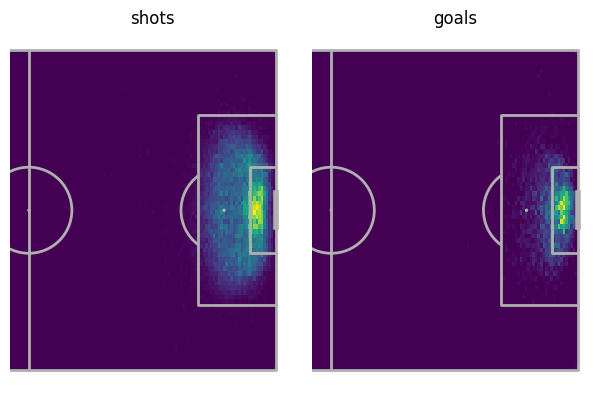

In [10]:
pitch = Pitch(pitch_type='uefa', half=True)
fig, axs = pitch.grid(figheight=5, ncols=2, endnote_height=0.0, title_height=0.0)
axs[0].imshow(distmat, extent=pitch.visible_pitch, interpolation='none')
axs[0].set_title("shots")
axs[1].imshow(distmat_goals, extent=pitch.visible_pitch, interpolation='none')
axs[1].set_title("goals")
plt.show()

In [11]:
# Distribution of open play shots for a specific body part using a 1x1m grid 
distmat_bodypart = {}
for bodypart in ["foot", "head", "other"]:
    df_shots_bodypart = df_shots[df_shots.bodypart_name_simple == bodypart]
    distmat_bodypart[bodypart] = count(
        df_shots_bodypart.start_x, 
        df_shots_bodypart.start_y, 
        n=spadl_config["length"], m=spadl_config["width"]
    )
    np.divide(distmat_bodypart[bodypart], distmat, out=np.zeros_like(distmat), where=distmat!=0)
    np.savetxt(
        output_dir/ f"shot_{bodypart}_distribution.csv", 
        np.divide(distmat_bodypart[bodypart], distmat, out=np.zeros_like(distmat), where=distmat!=0),
        delimiter=","
    )

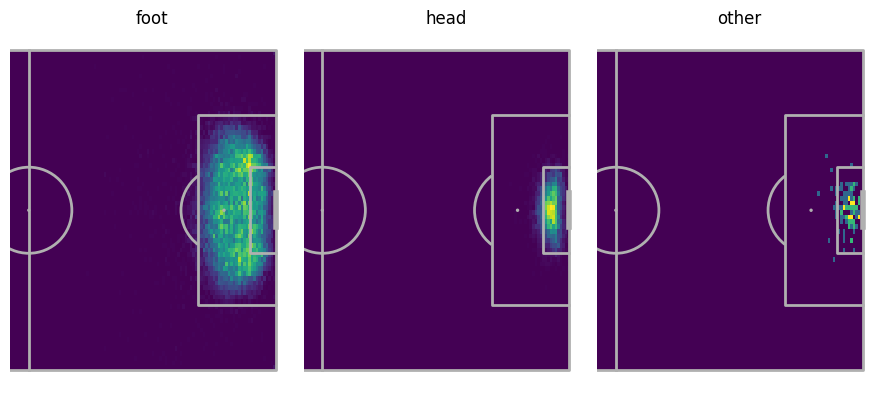

In [12]:
pitch = Pitch(pitch_type='uefa', half=True)
fig, axs = pitch.grid(figheight=5, ncols=3, endnote_height=0.0, title_height=0.0)
for i, bodypart in enumerate(["foot", "head", "other"]):
    axs[i].imshow(distmat_bodypart[bodypart], extent=pitch.visible_pitch, interpolation='none')
    axs[i].set_title(bodypart)
plt.show()

## xG model

In [13]:
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.linear_model import LogisticRegression

from soccer_xg.ml.pipeline import ColumnsSelector

In [14]:
fNUM = ['start_x_shot', 'start_y_shot', 'dist_shot', 'angle_shot']  # numerical features
fBIN = ['bodypart_head_shot', 'bodypart_other_shot']  # binary features

binpipe = make_pipeline(
    ColumnsSelector(fBIN),
)
numpipe = make_pipeline(
    ColumnsSelector(fNUM),
)
clf = LogisticRegression(max_iter=100_000, fit_intercept=True, random_state=1234, class_weight=None, penalty='l2', solver="newton-cholesky")

In [15]:
games_train, games_val, games_test = utils.sample_temporal(dataset, size_val=0.0, size_test=0.1)

X_train, y_train = df_shot_features.loc[games_train], df_shot_labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = df_shot_features.loc[games_val], df_shot_labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = df_shot_features.loc[games_test], df_shot_labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

In [16]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (38704, 14)
--------------------
dataset = val
shape = (0, 14)
--------------------
dataset = test
shape = (4348, 14)
--------------------


In [17]:
pipe = Pipeline(
    [
        ('preprocessing', make_union(numpipe, binpipe)),
        ('clf', clf),
    ]
)
pipe.fit(X_train, y_train['goal'])
#pipe.fit(df_shot_features, df_shot_labels['goal'])

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('columnsselector',
                                                                  ColumnsSelector(columns=['start_x_shot',
                                                                                           'start_y_shot',
                                                                                           'dist_shot',
                                                                                           'angle_shot']))])),
                                                ('pipeline-2',
                                                 Pipeline(steps=[('columnsselector',
                                                                  ColumnsSelector(columns=['bodypart_head_shot',
                                                                                           'bodypart_other_shot']))]))])),
                ('clf',
                 LogisticRegression(max_iter=100000, random_state=1234,
                                    solver='newton-cholesky'))])

In [18]:
# Model
log_model = pipe['clf']

In [19]:
# Coefficients
a = log_model.intercept_[0]
b = list(zip(fNUM + fBIN, log_model.coef_[0]))
print(b, a)

[('start_x_shot', -0.12903395599643458), ('start_y_shot', 0.0007081390917351433), ('dist_shot', -0.3135102634670339), ('angle_shot', 0.09095528657468613), ('bodypart_head_shot', -1.2946488935455571), ('bodypart_other_shot', -0.1929243274609438)] 14.301040398978596


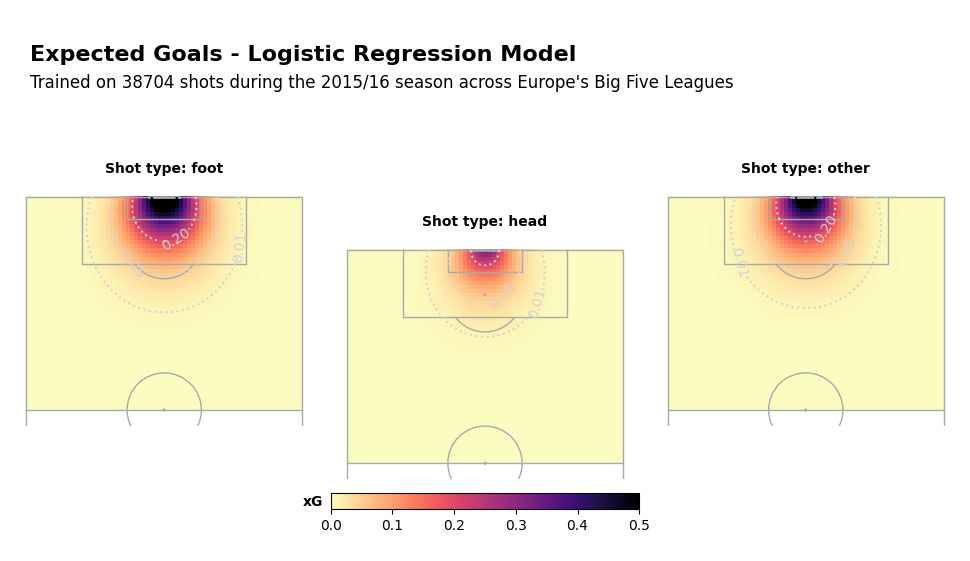

In [20]:
colorscheme = "light"
textcolor = "white" if colorscheme == "dark" else "black"
annotationcolor = 'darkgrey' if colorscheme == "dark" else "lightgray"

#%% Create an xG test-set, and predict on test set
PITCH_LENGTH_X = 105
PITCH_WIDTH_Y = 68
GOAL_WIDTH_Y = 7.32

# Initialise arrays for ground and header test-sets
prob_goal_grnd = np.zeros((int(1+PITCH_LENGTH_X/2), int(1+PITCH_WIDTH_Y)))
prob_goal_head = np.zeros((int(1+PITCH_LENGTH_X/2), int(1+PITCH_WIDTH_Y)))
prob_goal_other = np.zeros((int(1+PITCH_LENGTH_X/2), int(1+PITCH_WIDTH_Y)))

# Create array of shots
dists = list()
probs = list()

for x_pos in range(int(PITCH_LENGTH_X/2 + 1), PITCH_LENGTH_X):
    for y_pos in range(0, int(PITCH_WIDTH_Y + 1)):
        dx = (105 - x_pos)
        dy = (68 / 2 - y_pos)
        with np.errstate(divide="ignore", invalid="ignore"):
            angle = np.nan_to_num(np.arctan(abs(dy) / abs(dx)))
        distance = np.sqrt(dx**2 + dy**2)
        prob_goal_grnd[105-x_pos-1, y_pos] = log_model.predict_proba([[x_pos, y_pos, distance, angle, 0, 0]])[0,1]
        prob_goal_head[105-x_pos-1, y_pos] = log_model.predict_proba([[x_pos, y_pos, distance, angle, 1, 0]])[0,1]
        prob_goal_other[105-x_pos-1, y_pos] = log_model.predict_proba([[x_pos, y_pos, distance, angle, 0, 1]])[0,1]

        dists.append(distance)
        probs.append(prob_goal_grnd[105-x_pos-1, y_pos])

# %% Plot xG model

# Overwrite rcParams
mpl.rcParams['xtick.color'] = "white" if colorscheme == "dark" else "black"
mpl.rcParams['ytick.color'] = "white" if colorscheme == "dark" else "black"
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Plot pitches
pitch = VerticalPitch(
    half=True, 
    pitch_color='#313332' if colorscheme == "dark" else 'white', 
    line_color='white' if colorscheme == "dark" else "darkgrey", 
    linewidth=1, 
    stripe=False,
    pitch_type='custom',  # example plotting a tracab pitch
    pitch_length=105, pitch_width=68
)
fig, ax = pitch.grid(nrows=1, ncols=3, grid_height=0.75, space = 0.1, axis=False)
fig.set_size_inches(10, 5.5)
fig.set_facecolor('#313332' if colorscheme == "dark" else 'white')

# Add xG maps and contours
pos1 = ax['pitch'][0].imshow(prob_goal_grnd, extent = (68,0,52.5,105) ,aspect='equal',vmin=-0.0,vmax=0.5,cmap=plt.cm.magma_r)
pos2 = ax['pitch'][1].imshow(prob_goal_head, extent = (68,0,52.5,105) ,aspect='equal',vmin=-0.0,vmax=0.5,cmap=plt.cm.magma_r)
pos3 = ax['pitch'][2].imshow(prob_goal_other, extent = (68,0,52.5,105) ,aspect='equal',vmin=-0.0,vmax=0.5,cmap=plt.cm.magma_r)
cs1 = ax['pitch'][0].contour(prob_goal_grnd, extent = (68,0,105,52.5), levels = [0.01,0.05,0.2,0.5], colors = [annotationcolor,annotationcolor,annotationcolor,'k'], linestyles = 'dotted')
cs2 = ax['pitch'][1].contour(prob_goal_head, extent = (68,0,105,52.5), levels = [0.01,0.05,0.2,0.5], colors = [annotationcolor, annotationcolor,annotationcolor,'k'], linestyles = 'dotted')
cs3 = ax['pitch'][2].contour(prob_goal_other, extent = (68,0,105,52.5), levels = [0.01,0.05,0.2,0.5], colors = [annotationcolor, annotationcolor,annotationcolor,'k'], linestyles = 'dotted')
ax['pitch'][0].clabel(cs1)
ax['pitch'][1].clabel(cs2)
ax['pitch'][2].clabel(cs3)
ax['pitch'][0].set_title("Shot type: foot", fontsize=10, color=textcolor, fontweight="bold")
ax['pitch'][1].set_title("Shot type: head", fontsize=10, color=textcolor, fontweight="bold")
ax['pitch'][2].set_title("Shot type: other", fontsize=10, color=textcolor, fontweight="bold")

# Title
fig.text(0.045,0.9,"Expected Goals - Logistic Regression Model", fontsize=16, color=textcolor, fontweight="bold")
fig.text(0.045,0.85,f"Trained on {len(X_train)} shots during the 2015/16 season across Europe's Big Five Leagues", fontsize=12, color=textcolor, fontweight="regular")

# Colourbar
cbar = fig.colorbar(pos2, ax=ax['pitch'][1], location="bottom",  fraction = 0.04, pad = 0.0335)
cbar.ax.set_ylabel('xG', loc="bottom", color = textcolor, fontweight="bold", rotation=0, labelpad=20)

# Format and show
plt.tight_layout()
plt.show()

In [21]:
data_test = X_test.assign(goal=y_test.goal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'max_dev': 15.690095111005931, 'residual_area': 191.7934953178488, 'roc': 0.799006238358854, 'brier': 0.07925814032083137, 'ece': 0.014138825166803835, 'ace': 0.012252520916267318, 'fig': <Figure size 1000x500 with 3 Axes>}


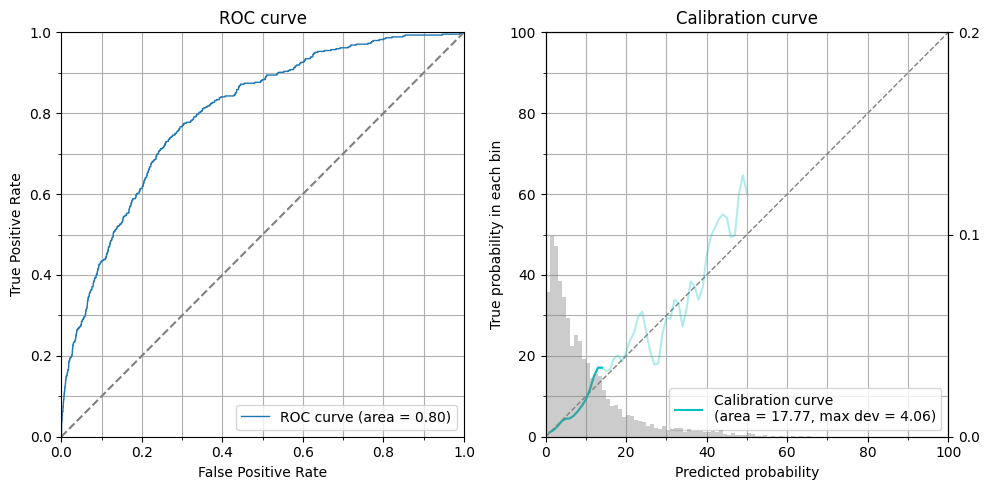

In [22]:
model = xg.OpenplayXGModel()
model.model = pipe
model._training_seasons = ["1516"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))

In [23]:
dataset.close()